In [1]:
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import numpy
import cv2  
import os

## Essentials

### Image cropping

In [24]:
def crop_terminal_part(img: Image.Image, video_id: int):
    if(video_id == 1):
        return img.crop((73, 76, 543, 510))
    elif(video_id == 2):
        return img
    else:
        raise ValueError(f"Unknown video_id {video_id}")

### Char boundary detection

In [3]:
detect_threshold = 96
detect_required_count = 20

In [4]:
def grayscale_at(img: Image.Image, xy: tuple[int, int]):
    if 0 <= xy[0] < img.size[0] and 0 <= xy[1] < img.size[1]:
        color = img.getpixel(xy)
        return color[0] * 0.3 + color[1] * 0.5 + color[2] * 0.2
    return 0

def linear_grayscale_at(img: Image.Image, xy: tuple[int, int]):
    return (grayscale_at(img, xy) / 255) ** 2.2    


In [5]:
def check_map_to_ranges(check: list[bool]) -> list[tuple[int, int]]:
    prev = -1
    ret = []
    for i, c in enumerate(check + [False]):
        if c and prev == -1:
            prev = i
        if not c and prev != -1:
            ret.append((prev, i))
            prev = -1
    return ret


In [6]:
def detect_row_range(img: Image.Image):
    width, height = img.size
    row_map = [ False ] * height
    for i in range(height):
        count = 0
        for j in range(width):
            value = grayscale_at(img, (j, i))
            if value >= detect_threshold:
                count += 1
        if count >= detect_required_count:
            row_map[i] = True
    return check_map_to_ranges(row_map)


In [7]:
def detect_col_range(img: Image.Image):
    width, height = img.size
    col_map = [ False ] * width
    for i in range(width):
        count = 0
        for j in range(height):
            value = grayscale_at(img, (i, j))
            if value >= detect_threshold:
                count += 1
        if count >= detect_required_count:
            col_map[i] = True
    return check_map_to_ranges(col_map)


In [8]:
def display_ranges(img: Image.Image, row_range, col_range):
    pad = 8
    width, height = img.size
    ret = Image.new('RGB', (width + pad, height + pad), (0, 0, 0))
    ret.paste(img, (pad, pad))
    draw = ImageDraw.Draw(ret)
    for r in row_range:
        draw.rectangle((0, pad + r[0], 8 - 1, pad + r[1] - 1), fill=(255, 255, 0)) # The range is inclusive
    for c in col_range:
        draw.rectangle((pad + c[0], 0, pad + c[1] - 1, 8 - 1), fill=(255, 0, 255)) # The range is inclusive
    return ret
    

In [9]:
def ranges_safety_check__(ranges, thresh):
    min_len = 998244353
    max_len = 0
    assert len(ranges) > 0, 'No ranges detected!'
    for c in ranges:
        length = c[1] - c[0]
        min_len = min(min_len, length)
        max_len = max(max_len, length)
    assert max_len - min_len <= thresh, 'Too large range length difference!'
    

### Individual char detection

In [10]:
def pil_to_cv2(image: Image.Image):
    return cv2.cvtColor(numpy.asarray(image), cv2.COLOR_RGB2BGR)

In [11]:
# Load sample masks
sample_masks = []
def reload_masks():
    global sample_masks
    sample_masks = [
        [c]
        for c in ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'void')
    ]
    for mask in sample_masks:
        i = 0
        while True:
            filename = f"sample-masks/{mask[0]}.{i}.png"
            if not os.path.exists(filename):
                break
            img = pil_to_cv2(Image.open(filename))
            mask.append(img)
            i += 1
        assert i > 0, f"Character {mask[0]} has no mask"


In [12]:
def detect_one_char(cropped_cv2_img):
    best_score, second_best_score = 9e9, 9e9
    best_match = None
    for mask_meta in sample_masks:
        char = mask_meta[0]
        if char == 'void': char = ' '
        current_score = 9e9
        for mask in mask_meta[1:]:
            result = cv2.matchTemplate(cropped_cv2_img, mask, cv2.TM_SQDIFF_NORMED)
            (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(result)
            current_score = min(current_score, minVal)
        if current_score <= best_score:
            second_best_score = best_score
            best_score = current_score
            best_match = char
        elif current_score <= second_best_score:
            second_best_score = current_score
    confidence_ratio = 9e9
    if best_score != 0:
        confidence_ratio = second_best_score / best_score
    if confidence_ratio < 1.5:
        return (best_match, confidence_ratio)
    return best_match
                        

### Detect chars in hex screen

In [13]:
def detect_full_hex_screen(img: Image.Image):
    row_range = detect_row_range(img)
    col_range = detect_col_range(img)
    assert len(col_range) == 39, f"Incorrect number of columns {len(col_range)}"
    ranges_safety_check__(row_range, 7)
    ranges_safety_check__(col_range, 4)
    
    detection_pad = 4
    padded_img = Image.new('RGB', (
        img.size[0] + detection_pad + detection_pad, img.size[1] + detection_pad + detection_pad
    ), (0,0,0))
    padded_img.paste(img, (detection_pad, detection_pad))
    img = pil_to_cv2(padded_img)
    
    ret: list[str] = []
    for ri, r in enumerate(row_range):
        curr_line = ''
        for ci, c in enumerate(col_range):
            cropped = img[r[0]:r[1]+detection_pad+detection_pad, c[0]:c[1]+detection_pad+detection_pad]
            detection_result = detect_one_char(cropped)
            assert type(detection_result) == type(''), f"Low confidence {detection_result} at ({ci}, {ri})"
            assert detection_result not in ' ', f"Unexpected detection result {detection_result} at ({ci}, {ri})"
            curr_line += detection_result
        ret.append(curr_line)
    return ret


## Get the fan spinning!

### Process one image from start to end

In [14]:
def process_image(video_set: int, frame_number: int):
    input_filename = f"frames/{video_set}-{str(frame_number).zfill(4)}.png"
    output_filename = f"output/{video_set}-{str(frame_number).zfill(4)}.txt"
    img = Image.open(input_filename)
    img = crop_terminal_part(img, video_set)
    rec_result = detect_full_hex_screen(img)
    prev_addr = None
    buffer = ''
    for line in rec_result:
        addr_spec = line[0:7]
        addr = int(addr_spec, 16)
        if prev_addr != None and addr != prev_addr + 16:
            raise ValueError(f'Address violation at {addr_spec}')
        prev_addr = addr
        rest_spec = ''
        rest = line[7:]
        for char in rest:
            if len(rest_spec) > 0 and len(rest_spec) % 5 == 4:
                rest_spec += ' '
            rest_spec += char
        buffer += f'{addr_spec} {rest_spec}\n'
    os.makedirs('output/', exist_ok=True)
    open(output_filename, 'w', encoding='utf-8').write(buffer)
    

### Batch process

In [15]:
raise RuntimeError('Do not execute further below. The block below is batch processing.')

RuntimeError: Do not execute further below. The block below is batch processing.

In [25]:
reload_masks()

fp_log = open("log.txt", "w", encoding='utf-8')
fp_error = open("error.txt", "w", encoding='utf-8')

for name in os.listdir('frames'):
    if not '.png' in name: continue
    video_set = int(name[0])
    frame_number = int(name[2:6])
    specifier = f"{video_set}-{str(frame_number).zfill(4)}"
    should_output = f"output/{video_set}-{str(frame_number).zfill(4)}.txt"
    if(os.path.exists(should_output)):
        continue
    try:
        process_image(video_set, frame_number)
        fp_log.write(f"{specifier} | Successful.\n")
    except Exception as e:
        err_line = f"{specifier} | {repr(e)}\n"
        fp_log.write(err_line)
        fp_error.write(err_line)
    
    fp_log.flush()
    fp_error.flush()
    
fp_log.close()
fp_error.close()

### Validation and dumping

In [36]:
max_addr = 0
addr_content_map = {}
for name in os.listdir('output'):
    filename = f"output/{name}"
    lines = open(filename, 'r', encoding='utf-8').read().split("\n")
    for line in lines:
        if line.strip() == '': continue
        addr_spec = line.split(' ')[0]
        addr = int(addr_spec, 16)
        addr_content_map[addr] = line[len(addr_spec) + 1:]
        max_addr = max(max_addr, addr)

os.makedirs('dist/', exist_ok=True)
dump_fp = open('dist/secret.hexdump', 'w', encoding='utf-8')

seg_start = None
for addr in range(0, max_addr + 32, 16):
    rest_spec = ''
    if addr <= max_addr:
        rest_spec = addr_content_map.get(addr)
        dump_fp.write(f'{hex(addr)[2:].zfill(7)} {rest_spec}\n')
    if None == rest_spec and seg_start == None:
        seg_start = addr
    if None != rest_spec and seg_start != None:
        print(f'Missing segment ({hex(seg_start)}, {hex(addr)})')
        seg_start = None

dump_fp.close()
print(f'max_addr: {hex(max_addr)}')


max_addr: 0x7fff0


### Binary reconstruction

In [38]:
dump_fp = open('dist/secret.hexdump', 'r', encoding='utf-8')
secret_fp = open('dist/secret', 'wb')

for line in dump_fp.read().split("\n"):
    if line.strip() == '': continue
    for hex_int16 in line.split(" ")[1:]:
        bytes_int16 = bytes.fromhex(hex_int16[2:4] + hex_int16[0:2])
        secret_fp.write(bytes_int16)

secret_fp.close()
dump_fp.close()


## Tests and data construction

In [ ]:
raise RuntimeError('Do not execute further below. They are for tests and data construction.')

RuntimeError: Do not execute further below. They are for tests and data construction.

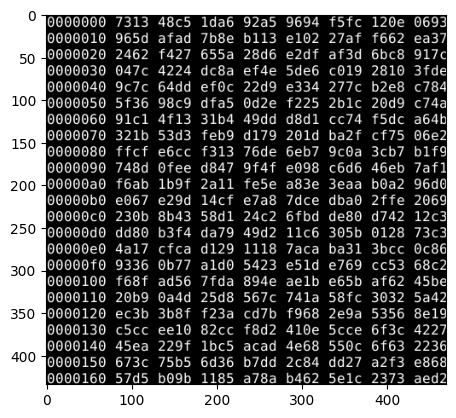

In [ ]:
# Test image cropping
img = crop_terminal_part(Image.open("frames/1-0000.png"), 1)
plt.imshow(img)


[(3, 15), (22, 34), (41, 53), (60, 72), (79, 91), (98, 110), (117, 129), (136, 148), (155, 167), (174, 186), (193, 205), (212, 224), (231, 243), (250, 262), (269, 281), (288, 300), (307, 319), (326, 338), (345, 357), (364, 376), (383, 395), (402, 414), (421, 433)]
[(2, 10), (12, 20), (22, 30), (32, 40), (42, 50), (52, 60), (62, 70), (82, 90), (92, 100), (102, 110), (112, 120), (132, 140), (142, 150), (152, 160), (162, 170), (182, 189), (192, 200), (202, 210), (212, 220), (232, 240), (242, 250), (252, 259), (262, 270), (282, 290), (292, 300), (302, 310), (312, 320), (332, 340), (342, 350), (352, 360), (362, 370), (382, 390), (392, 400), (402, 410), (412, 420), (432, 440), (442, 450), (452, 460), (462, 470)]


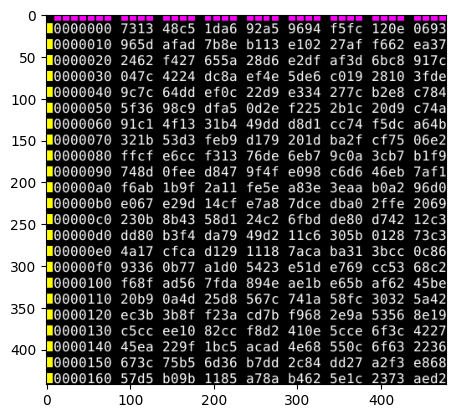

In [ ]:
# Test char boundary detection
row_range = detect_row_range(img)
col_range = detect_col_range(img)
print(row_range)
print(col_range)
range_display_img = display_ranges(img, row_range, col_range)
plt.imshow(range_display_img)
ranges_safety_check__(row_range, 7)
ranges_safety_check__(col_range, 10)


In [ ]:
# Save sample masks
for cy in range(0, 16):
    cx = 5
    filename = hex(cy)[2:]
    mask = img.crop((col_range[cx][0], row_range[cy][0], col_range[cx][1], row_range[cy][1]))
    mask.save(f"sample-masks/{filename}.0.png")

'4'

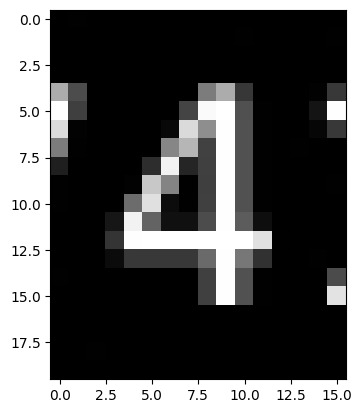

In [ ]:
# Test individual char recog
cx, cy = 24,17
cropped = img.crop((col_range[cx][0] - 4, row_range[cy][0] - 4, col_range[cx][1] + 4, row_range[cy][1] + 4))
plt.imshow(cropped)
detect_one_char(pil_to_cv2(cropped))


In [ ]:
# Augmentation
image_id = input("What is the digit?")
cropped = img.crop((col_range[cx][0], row_range[cy][0], col_range[cx][1], row_range[cy][1]))
i = 0
can_save = True
while True:
    filename = f"sample-masks/{image_id}.{i}.png"
    if not os.path.exists(filename):
        break
    i += 1
cropped.save(filename)


In [ ]:
# Test full screen detection
reload_masks()
img = crop_terminal_part(Image.open("frames/1-0000.png"), 1)
detect_full_hex_screen(img)


['0000000731348c51da692a59694f5fc120e0693',
 '0000010965dafad7b8eb113e10227aff662ea37',
 '00000202462f427655a28d6e2dfaf3d6bc8917c',
 '0000030047c4224dc8aef4e5de6c01928103fde',
 '00000409c7c64ddef0c22d9e334277cb2e8c784',
 '00000505f3698c9dfa50d2ef2252b1c20d9c74a',
 '000006091c14f1331b449ddd8d1cc74f5dca64b',
 '0000070321b53d3feb9d179201dba2fcf7506e2',
 '0000080ffcfe6ccf31376de6eb79c0a3cb7b1f9',
 '0000090748d0feed8479f4fe098c6d646eb7af1',
 '00000a0f6ab1b9f2a11fe5ea83e3eaab0a296d0',
 '00000b0e067e29d14cfe7a87dcedba02ffe2069',
 '00000c0230b8b4358d124c26fbdde80d74212c3',
 '00000d0dd80b3f4da7949d211c6305b012873c3',
 '00000e04a17cfcad12911187acaba313bcc0c86',
 '00000f093360b77a1d05423e51de769cc5368c2',
 '0000100f68fad567fda894eae1be65baf6245be',
 '000011020b90a4d25d8567c741a58fc30325a42',
 '0000120ec3b3b8ff23acd7bf9682e9a53568e19',
 '0000130c5ccee1082ccf8d2410e5cce6f3c4227',
 '000014045ea229f1bc5acad4e68550c6f632236',
 '0000150673c75b56d36b7dd2c84dd27a2f3e868',
 '000016057d5b09b1185a78ab4625e1